# Rodriguez model explanations

## First we need dataframes for every subject

In [4]:
import sys
sys.path.append('../')

%matplotlib inline

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import utils

pd.set_option('max_colwidth', 800) 

In [20]:
# DEFINE GRAPH
from importlib import reload
reload(utils)

<module 'utils' from '/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py'>

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 5

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [8]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [9]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [10]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [11]:
sequence_df = utils.get_sequence(args=args, subject_dfs=subject_dfs, subject=4)
y = sequence_df['Pain'].values
image_paths = sequence_df['Path'].values

Chose subject  4
Start index in subject dataframe:  6143


In [12]:
from keras.utils import np_utils
label_onehot = np_utils.to_categorical(y, num_classes=args.nb_labels)
batch_label = label_onehot.reshape(args.batch_size, -1)
batch_img = np.concatenate(utils.read_images_and_return_list(args, image_paths, 'local'), axis=1)

## t0, run4, rodriguez 512u.

In [13]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_rodriguez_adadelta_LSTMunits_512_CONVfilters_None_jpg128_2fps_val4_t0_seq10ss10_4hl_32ubs16_no_aug_run4.h5'
import keras
m = keras.models.load_model(best_model_path)

In [13]:
m.layers

In [32]:
[print(layer.input) for layer in m.layers]

Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1_3/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2_3/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1_3/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1_3/transpose_1:0", shape=(?, ?, 512), dtype=float32)


[None, None, None, None, None, None]

In [33]:
[print(layer.output) for layer in m.layers]

Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1_3/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2_3/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1_3/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1_3/transpose_1:0", shape=(?, ?, 512), dtype=float32)
Tensor("dense_2_3/Sigmoid:0", shape=(?, 10, 2), dtype=float32)


[None, None, None, None, None, None]

In [14]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])
model = utils.RodriguezNetwork(images, path=best_model_path)

In [15]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)
print('model preds: ', model.preds)
print('cost: ', cost)
    
y_c = tf.reduce_sum(tf.multiply(model.preds, labels), axis=1)

print('y_c: ', y_c)

target_conv_layer = model.timedist_vgg # Choose which layer to study

print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("dense_2_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("time_distributed_1_2/transpose_1:0", shape=(1, ?, 4, 4, 512), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_2_2/transpose_grad/transpose:0", shape=(1, ?, 4, 4, 512), dtype=float32)


In [21]:
def run_on_one_sequence(sess, model, batch_img):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        # print(batch_label)
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                      feed_dict={images: batch_img,
                      labels: batch_label,
                      K.learning_phase(): 0})
#         target_conv_layer_value = np.reshape(target_conv_layer_value,
#                                      (1, 10, 128, 128, 3))
#         target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
#                                      (1, 10, 128, 128, 3))
        target_conv_layer_value = np.reshape(target_conv_layer_value,
                                     (1, 10, 4, 4, 512))
        target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                     (1, 10, 4, 4, 512))

    utils.visualize_overlays(batch_img, target_conv_layer_value,
                       target_conv_layer_grad_value, args)
#     print('tcl: ')
#     print(target_conv_layer_value)
#     print('')
#     print('tclg: ')
#     print(target_conv_layer_grad_value)


Chose subject  0
Start index in subject dataframe:  9038
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001785.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001786.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001787.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001788.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001789.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001790.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001791.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001792.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001793.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001794.jpg     1
[[[0.21639208 0.80210936]
  [0.30609688 0.77079946]
  [0.1802449  0.7934728 ]
  [0.23609371 0.6051633 ]
  [0.2977881  0.47517994]
  [0.19536285 0.6378646 ]
  [0.16106988 0.7685913 ]
  [0.07112271 0.8266005 ]
  [0.04590712 0.9176637 ]
  [0.04485456 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


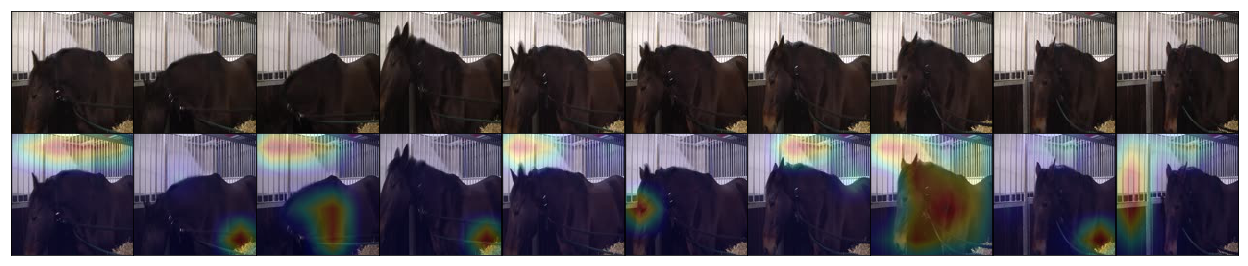

tcl: 
[[[[[ 0.          0.          0.         ...  0.          0.
      0.        ]
    [ 0.          0.          0.         ...  0.          0.
      0.        ]
    [ 0.          0.          0.         ...  0.         16.63988
      0.        ]
    [ 0.          0.          9.894083   ...  0.         16.254663
      0.        ]]

   [[ 0.          0.          0.         ...  0.          0.
      0.        ]
    [ 0.          0.         14.792003   ... 23.186304    0.
      0.        ]
    [ 0.          0.          6.8002543  ... 21.894705    0.
      0.        ]
    [ 0.          0.          0.         ...  0.          0.
      0.        ]]

   [[ 0.          0.          0.         ...  0.          0.
      0.        ]
    [ 0.          0.         19.546337   ... 10.131345    0.
      0.        ]
    [18.08345     0.         24.78314    ... 26.012106    0.
      0.        ]
    [14.9618635   0.          0.         ...  6.5851364   5.94203
      0.        ]]

   [[ 0.          0.    

In [37]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=9038)
run_on_one_sequence(sess, model, batch_img)

# Rodriguez predictions for subject 0

Chose subject  0
Start index in subject dataframe:  9038
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001785.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001786.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001787.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001788.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001789.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001790.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001791.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001792.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001793.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001794.jpg     1
[[[0.21639208 0.80210936]
  [0.30609688 0.77079946]
  [0.1802449  0.7934728 ]
  [0.23609371 0.6051633 ]
  [0.2977881  0.47517994]
  [0.19536285 0.6378646 ]
  [0.16106988 0.7685913 ]
  [0.07112271 0.8266005 ]
  [0.04590712 0.9176637 ]
  [0.04485456 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


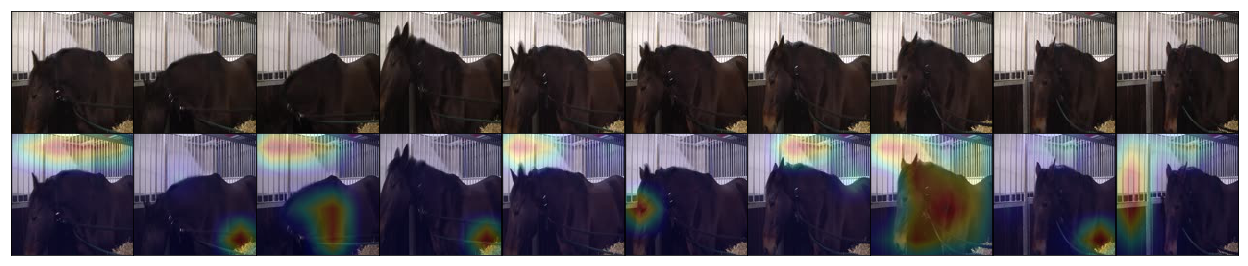

In [21]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=9038)
run_on_one_sequence(sess, model, batch_img)

Chose subject  0
Start index in subject dataframe:  9010
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001757.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001758.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001759.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001760.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001761.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001762.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001763.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001764.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001765.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_001766.jpg     1
[[[0.20859438 0.7846736 ]
  [0.22027805 0.6613428 ]
  [0.18885009 0.8769573 ]
  [0.12777361 0.8633755 ]
  [0.14042006 0.8924504 ]
  [0.1610401  0.8048762 ]
  [0.08736316 0.8256927 ]
  [0.08682739 0.89683336]
  [0.06399307 0.94171405]
  [0.03784152 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


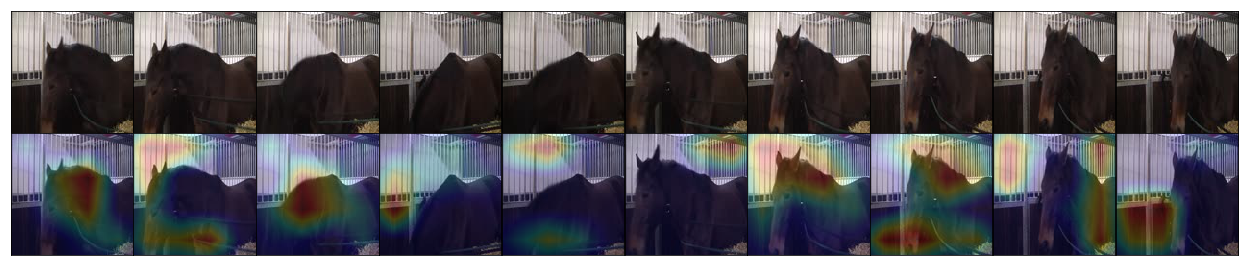

In [23]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=9010)
run_on_one_sequence(sess, model, batch_img)

Chose subject  0
Start index in subject dataframe:  2964
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_1b/frame_000293.jpg     0
1  data/jpg_128_128_2fps/horse_1/1_1b/frame_000294.jpg     0
2  data/jpg_128_128_2fps/horse_1/1_1b/frame_000295.jpg     0
3  data/jpg_128_128_2fps/horse_1/1_1b/frame_000296.jpg     0
4  data/jpg_128_128_2fps/horse_1/1_1b/frame_000297.jpg     0
5  data/jpg_128_128_2fps/horse_1/1_1b/frame_000298.jpg     0
6  data/jpg_128_128_2fps/horse_1/1_1b/frame_000299.jpg     0
7  data/jpg_128_128_2fps/horse_1/1_1b/frame_000300.jpg     0
8  data/jpg_128_128_2fps/horse_1/1_1b/frame_000301.jpg     0
9  data/jpg_128_128_2fps/horse_1/1_1b/frame_000302.jpg     0
[[[0.8841014  0.15891483]
  [0.91389036 0.1317175 ]
  [0.931651   0.1221413 ]
  [0.9223739  0.12323785]
  [0.9201644  0.10103973]
  [0.90935165 0.10113875]
  [0.9300208  0.08587848]
  [0.92264295 0.08473323]
  [0.9443651  0.09401051]
  [0.9411037  0.10292059]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


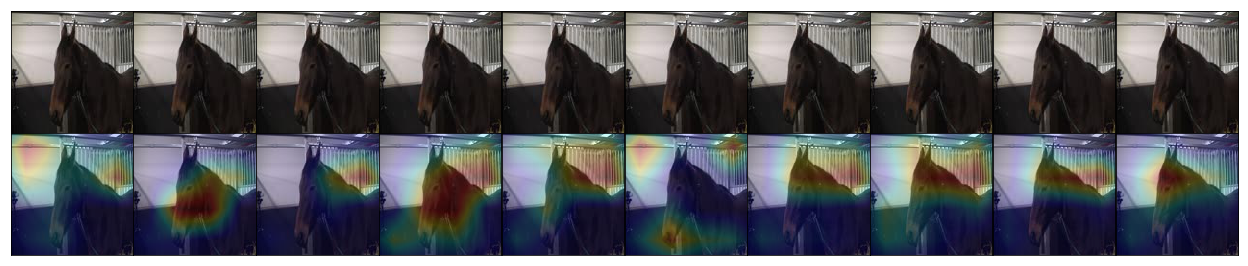

In [29]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=2964)
run_on_one_sequence(sess, model, batch_img)

Chose subject  0
Start index in subject dataframe:  13411
                                                   Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000638.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000639.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000640.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000641.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000642.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000643.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000644.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000645.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000646.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000647.jpg     1
[[[0.69912696 0.5404565 ]
  [0.72043484 0.5163127 ]
  [0.6595505  0.53489333]
  [0.6338091  0.43911174]
  [0.5250329  0.3930678 ]
  [0.56031126 0.21213348]
  [0.59691584 0.14808509]
  [0.38124353 0.28713477]
  [0.4627841  0.3389203 ]
  [0.6658097  0.3344078 ]]

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


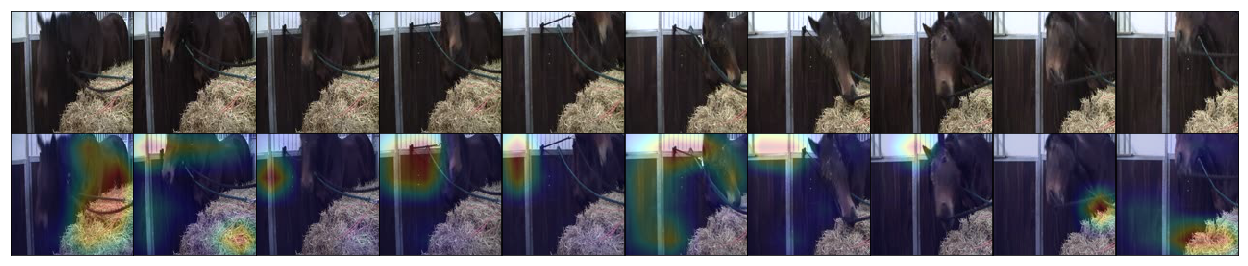

In [22]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=13411)
run_on_one_sequence(sess, model, batch_img)

Chose subject  0
Start index in subject dataframe:  1368
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000649.jpg     0
1  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000650.jpg     0
2  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000651.jpg     0
3  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000652.jpg     0
4  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000653.jpg     0
5  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000654.jpg     0
6  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000655.jpg     0
7  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000656.jpg     0
8  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000657.jpg     0
9  data/jpg_128_128_2fps/horse_1/1_1a_3/frame_000658.jpg     0
[[[0.7932184  0.29978424]
  [0.83690214 0.20486969]
  [0.8646118  0.19374102]
  [0.8703266  0.19955327]
  [0.90277475 0.14437938]
  [0.9211147  0.13250805]
  [0.9240892  0.1255072 ]
  [0.91835326 0.13136141]
  [0.91847706 0.13392708]
  [0.923948   0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


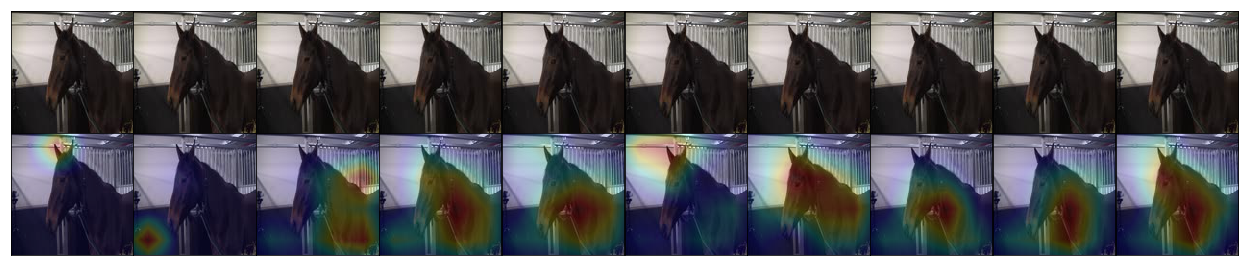

In [23]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=0, start_index=1368)
run_on_one_sequence(sess, model, batch_img)